# Previsão de séries temporais com Prophet em Python

## Bibliotecas e Configurações

In [2]:
!pip3 install fbprophet

In [1]:
import fbprophet

# print version number
print('Prophet %s' % fbprophet.__version__)

Prophet 0.7.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

from sklearn.metrics import mean_absolute_error

In [3]:
import seaborn as sns

sns.set(font_scale=1.4)
sns.set_style({'font.family': 'serif','fontname': 'Times New Roman'})

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  if np.any(y_true==0)==True:
    print('Erro: y_true contêm zeros!')
    return np.inf
  else:
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Importar e visualizar dados (série temporal)

In [5]:
# load data
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = pd.read_csv(path, header=0)

print(df.head(3))
print(df.tail(3))
#print(df.shape)
print()

df.info()

     Month  Sales
0  1960-01   6550
1  1960-02   8728
2  1960-03  12026
       Month  Sales
105  1968-10  21342
106  1968-11  17180
107  1968-12  14577

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   108 non-null    object
 1   Sales   108 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [6]:
df.columns = ['ds', 'y']
df['ds']=pd.to_datetime(df['ds'])

print(df.head(2))
print(df.tail(2))
print()
df.info()

          ds     y
0 1960-01-01  6550
1 1960-02-01  8728
            ds      y
106 1968-11-01  17180
107 1968-12-01  14577

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      108 non-null    datetime64[ns]
 1   y       108 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB


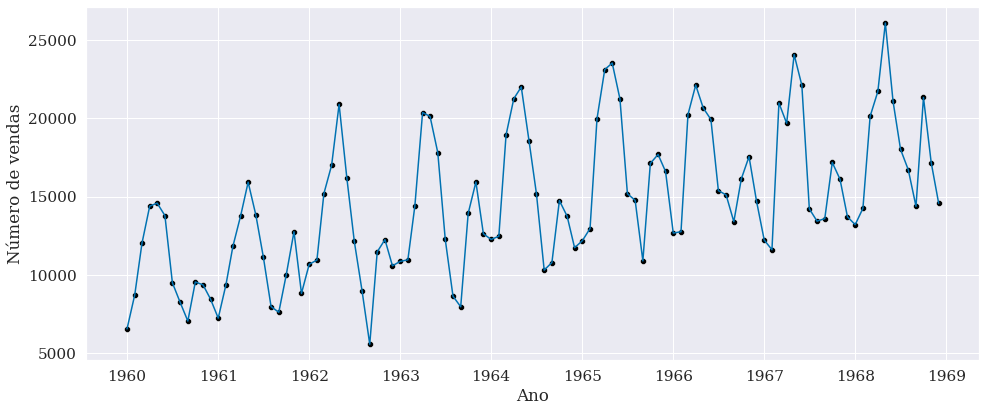

In [7]:
#df.plot(figsize=(10,5), style='.-'); plt.show()

plt.figure(figsize=(16,6.5))
Xlabel='Ano'; Ylabel='Número de vendas'

sns.scatterplot(data=df, x='ds', y='y', color='black')
sns.lineplot(data=df, x='ds', y='y', linewidth=1.5, color='#0072B2', label='')

#plt.legend(loc='lower right')
plt.xlabel(Xlabel)
plt.ylabel(Ylabel)
plt.show()

## Modelo de previsão

In [8]:
#Separar dados de treino e teste:
train = df.drop(df.index[-12:])
test  = df.loc[df.index[-12:]]

print(train.shape, test.shape)
print(train.tail(1),'\n',test.head(1))

(96, 2) (12, 2)
           ds      y
95 1967-12-01  13713 
            ds      y
96 1968-01-01  13210


In [9]:
%%time
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 2.83 s, sys: 157 ms, total: 2.99 s
Wall time: 3.01 s


In [10]:
##freq-> 'day', 'week', 'month', 'quarter', 'year', 1(1 sec), 60(1 minute) or 3600(1 hour).

#future = model.make_future_dataframe(periods=5, freq='MS')
future = model.make_future_dataframe(periods=len(test), freq='MS')
future.tail()

,ds
103,1968-08-01
104,1968-09-01
105,1968-10-01
106,1968-11-01
107,1968-12-01


In [11]:
forecast = model.predict(future)

## Resultados

In [12]:
#forecast.columns
forecast.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1960-01-01,9526.440702,4840.283790,7985.141888,9526.440702,9526.440702,-3078.492853,-3078.492853,-3078.492853,-3078.492853,-3078.492853,-3078.492853,0.0,0.0,0.0,6447.947850
1,1960-02-01,9634.541398,5377.183764,8356.295105,9634.541398,9634.541398,-2708.433957,-2708.433957,-2708.433957,-2708.433957,-2708.433957,-2708.433957,0.0,0.0,0.0,6926.107441


In [13]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
101,1968-06-01,20972.271640,19494.609105,22559.527206
102,1968-07-01,17359.551051,15849.194357,18911.172789
103,1968-08-01,14785.202961,13327.435903,16274.159148
104,1968-09-01,13521.380502,11919.566604,15053.117300
105,1968-10-01,17058.033238,15586.620521,18629.240181
106,1968-11-01,17418.680799,15799.447654,18947.214849
107,1968-12-01,15808.948450,14169.167058,17413.798478


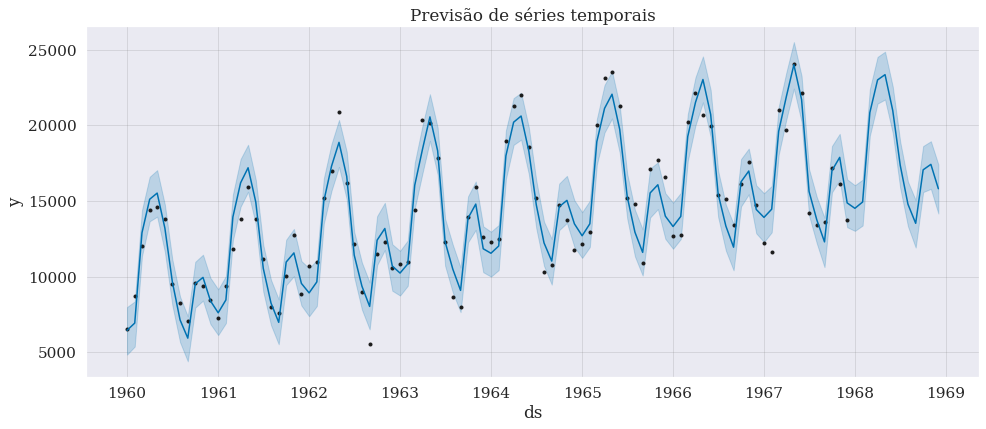

In [14]:
model.plot(forecast,figsize=(14,6))
plt.title('Previsão de séries temporais')
plt.show()

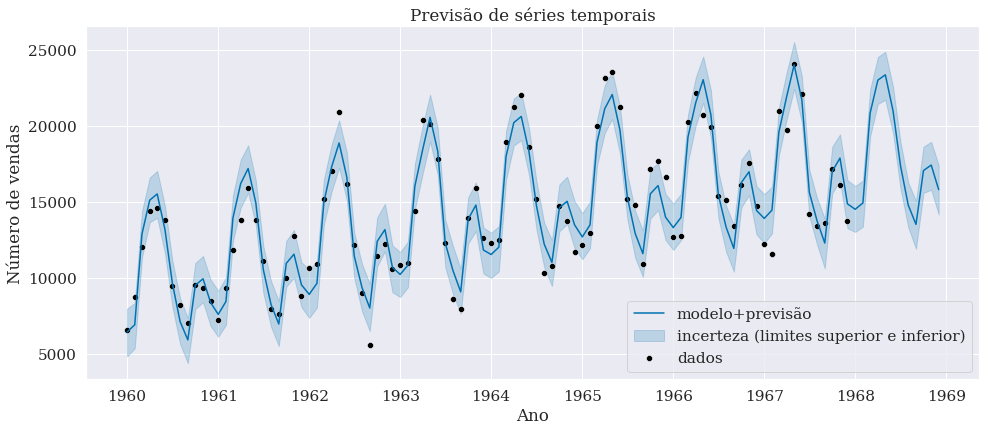

In [15]:
plt.figure(figsize=(16,6.5))
Xlabel='Ano'; Ylabel='Número de vendas'

plt.fill_between(forecast.ds.values, forecast.yhat_lower.values, forecast.yhat_upper.values,
                 color='#0072B2', alpha=0.2, label='incerteza (limites superior e inferior)')

sns.scatterplot(data=train, x='ds', y='y', color='black', label='dados')

sns.lineplot(data=forecast, x='ds', y='yhat', linewidth=1.5, color='#0072B2', label='modelo+previsão')
#plt.legend(loc='upper left')
plt.legend(loc='lower right')
plt.xlabel(Xlabel)
plt.ylabel(Ylabel)
plt.title('Previsão de séries temporais')
plt.show()

In [16]:
plot_plotly(model, forecast)

## Avaliando o erro:

In [17]:
y_true = test['y'].values
y_pred = forecast['yhat'][-12:].values
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f'MAE:  {round(mae,2)} vendas')
print(f'MAPE: {round(mape,2)}%')

MAE:  1336.81 vendas
MAPE: 7.19%


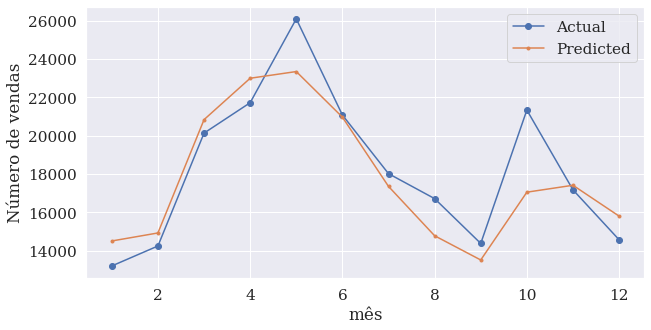

In [18]:
# plot expected vs actual
plt.figure(figsize=(10,5))
x=np.arange(1,len(y_true)+1,1)
plt.plot(x,y_true,'o-', label='Actual')
plt.plot(x,y_pred,'.-', label='Predicted')
plt.ylabel(Ylabel)
plt.xlabel('mês')
plt.legend()
plt.show()

## Componentes da previsão:
Tendência e sazonalidade anual da série temporal

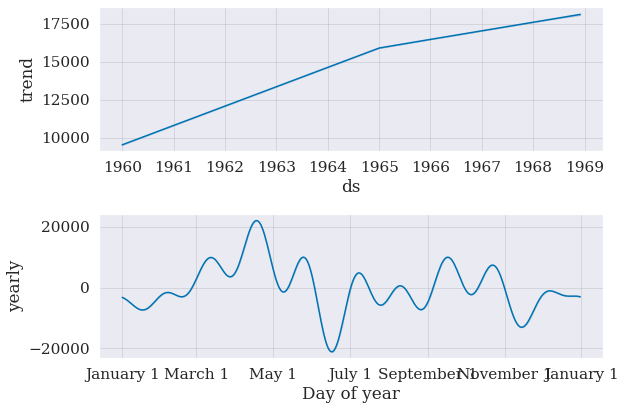

In [19]:
model.plot_components(forecast)
plt.show()

In [20]:
plot_components_plotly(model, forecast)

_________________
_________________